# RNN (Time Series)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('../data&resources/RSCCASN.csv',
                 index_col='DATE',
                 parse_dates=True
                )

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [5]:
df.columns = ['Sales']

<AxesSubplot:xlabel='DATE'>

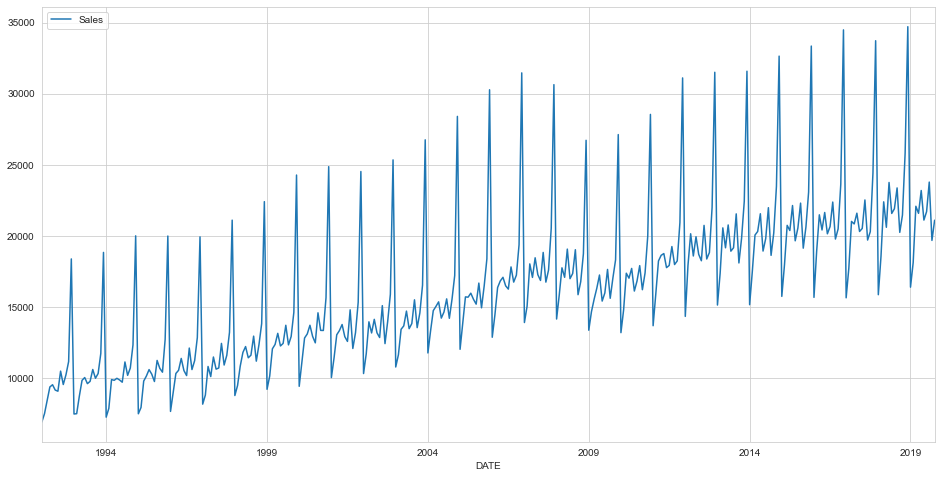

In [6]:
df.plot(figsize=(16,8))

## Preprocessing of Data

### Train Test Split

In [7]:
len(df)

334

In [8]:
len(df)- 18

316

In [9]:
test_size = 18

In [10]:
test_ind = len(df)- test_size

In [11]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [12]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [13]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


### Scaling

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
scaler = MinMaxScaler()

In [16]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [17]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# help(TimeseriesGenerator)

In [19]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [20]:
len(generator)

304

In [21]:
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [22]:
X, y = generator[0]

In [23]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


## Modelling

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [25]:
n_features = 1

In [26]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [30]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [31]:
len(validation_generator)

6

In [32]:
model.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
304/304 [==============================] - 6s 13ms/step - loss: 0.0233 - val_loss: 0.0029
Epoch 2/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0184 - val_loss: 0.0208
Epoch 3/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 4/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0042 - val_loss: 7.5653e-04
Epoch 5/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0034 - val_loss: 6.4815e-04
Epoch 6/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0018 - val_loss: 4.2254e-040s - loss
Epoch 7/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0022 - val_loss: 2.5843e-04
Epoch 8/20
304/304 [==============================] - 4s 13ms/step - loss: 0.0015 - val_loss: 1.8508e-04
Epoch 9/20
304/304 [==============================] - 4s 14ms/step - loss: 0.0019 - val_loss: 8.3678e-04
Epoch 10/20
304/304 [==============================] - 4s 

<AxesSubplot:>

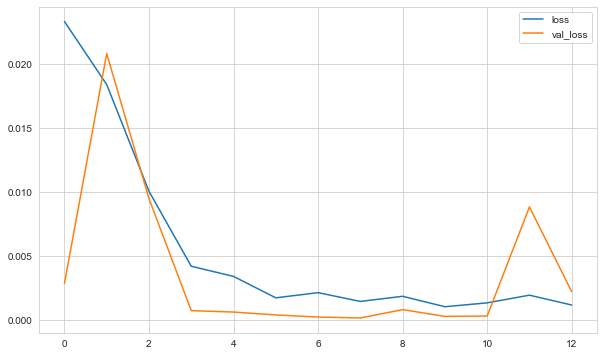

In [33]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Evaluate on Test Data

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [35]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [36]:
y_pred = model.predict(validation_generator)

In [37]:
y_pred

array([[0.63411176],
       [0.56503195],
       [0.57647955],
       [0.6232534 ],
       [0.5291423 ],
       [0.5683595 ]], dtype=float32)

In [38]:
test_scaled[-6:]

array([[0.59040081],
       [0.51499419],
       [0.53645077],
       [0.61185739],
       [0.46314987],
       [0.51463114]])

In [39]:
eval_metrics(test_scaled[-6:], y_pred)

r2_score: 0.10018871362871651 
 mae: 0.04414905176779938 
 mse: 0.0022313894536610183 
 rmse: 0.04723758518024623


In [40]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [41]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.9206627905612044 
 mae: 0.02859841812021268 
 mse: 0.001398487533062007 
 rmse: 0.037396357216472394


### Inverse Transformations and Comparing

In [42]:
true_predictions = scaler.inverse_transform(test_predictions)

In [43]:
test['Predictions'] = true_predictions

In [44]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22465.057
2018-06-01,21589,21391.753
2018-07-01,21919,21598.655
2018-08-01,23381,23308.787
2018-09-01,20260,21013.128
2018-10-01,21473,21570.911
2018-11-01,25831,25146.591
2018-12-01,34706,34245.591
2019-01-01,16410,17267.933


<AxesSubplot:xlabel='DATE'>

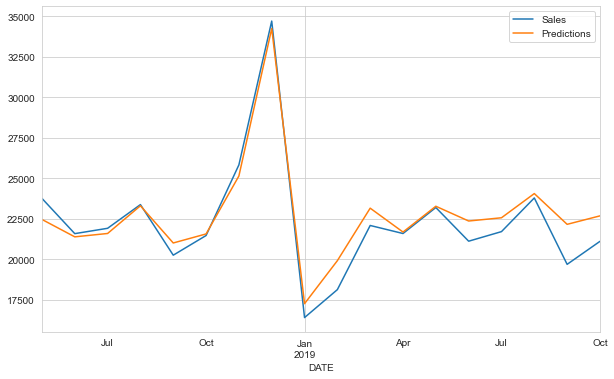

In [45]:
test.plot()

In [46]:
eval_metrics(test.Sales, test.Predictions)

r2_score: 0.9206627905612045 
 mae: 787.7148287031372 
 mse: 1060993.2441800148 
 rmse: 1030.0452631705148


## Retrain and Forecasting

In [47]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [48]:
length = 12 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [50]:
len(df)

334

In [49]:
len(generator)

322

In [51]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 5s 9ms/step - loss: 0.0236
Epoch 2/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0177
Epoch 3/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0107
Epoch 4/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0039
Epoch 5/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0035
Epoch 6/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0018
Epoch 7/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0014
Epoch 8/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0018
Epoch 9/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0021
Epoch 10/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0014
Epoch 11/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0011
Epoch 12/15
322/322 [==============================] - 3s 9ms/step - loss: 0.0014
Epoch 13/15
322/322 [

In [52]:
scaled_full_data.shape

(334, 1)

In [53]:
scaled_full_data[-length:].shape

(12, 1)

In [54]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 24

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [55]:
forecast = scaler.inverse_transform(forecast)

In [56]:
forecast

array([[25675.62985659],
       [34085.57311344],
       [17708.82867122],
       [19340.67268538],
       [22386.0366497 ],
       [22047.04804039],
       [23321.73419428],
       [21717.21054745],
       [22206.53587675],
       [23810.52431297],
       [20733.84642363],
       [21809.04513597],
       [25678.67858696],
       [33680.73225641],
       [18767.44898868],
       [20373.85736489],
       [22759.85663414],
       [22521.0082283 ],
       [23559.06562281],
       [22275.86370993],
       [22699.34664202],
       [23964.22005415],
       [21564.77238703],
       [22438.10640335]])

In [57]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [58]:
forecast_index = pd.date_range(start = '2019-11-01', periods = periods, freq = 'MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [59]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01',
               '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [60]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [61]:
forecast_df

,Forecast
2019-11-01,25675.630
2019-12-01,34085.573
2020-01-01,17708.829
2020-02-01,19340.673
2020-03-01,22386.037
2020-04-01,22047.048
2020-05-01,23321.734
2020-06-01,21717.211
2020-07-01,22206.536
2020-08-01,23810.524


<AxesSubplot:>

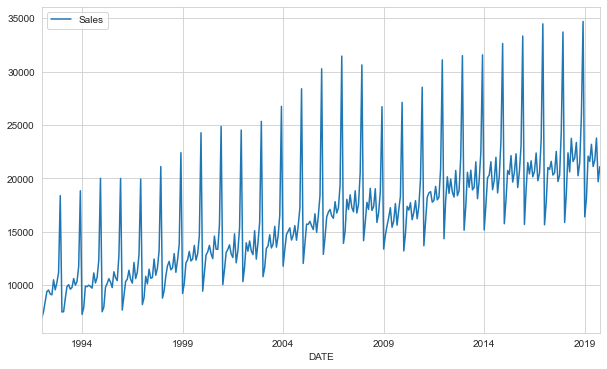

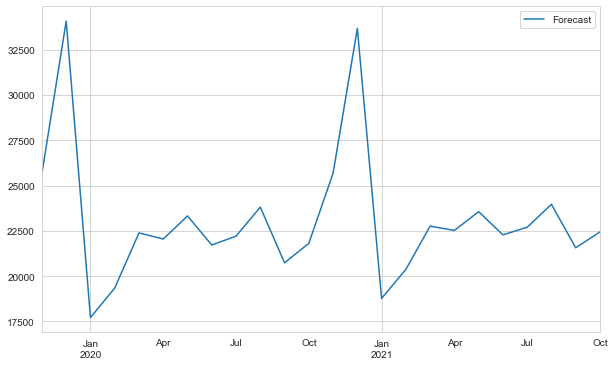

In [62]:
df.plot()
forecast_df.plot()

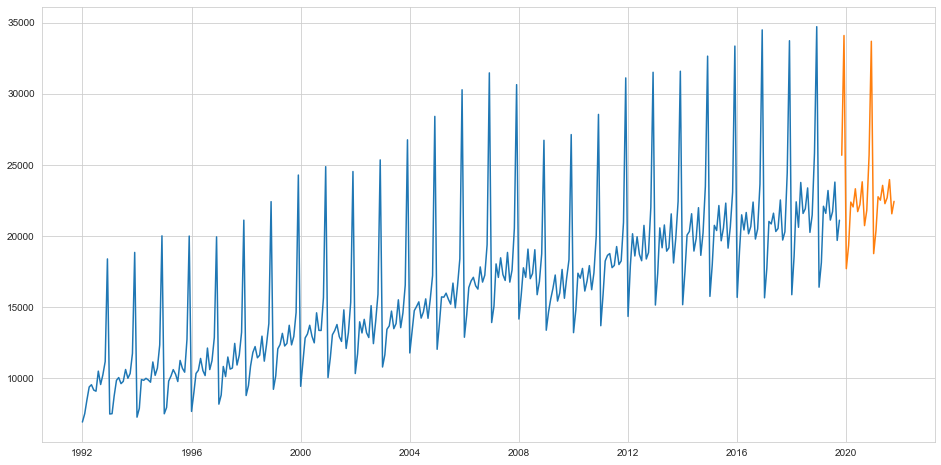

In [63]:
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast'])
#plt.plot(forecast_index, forecast)

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

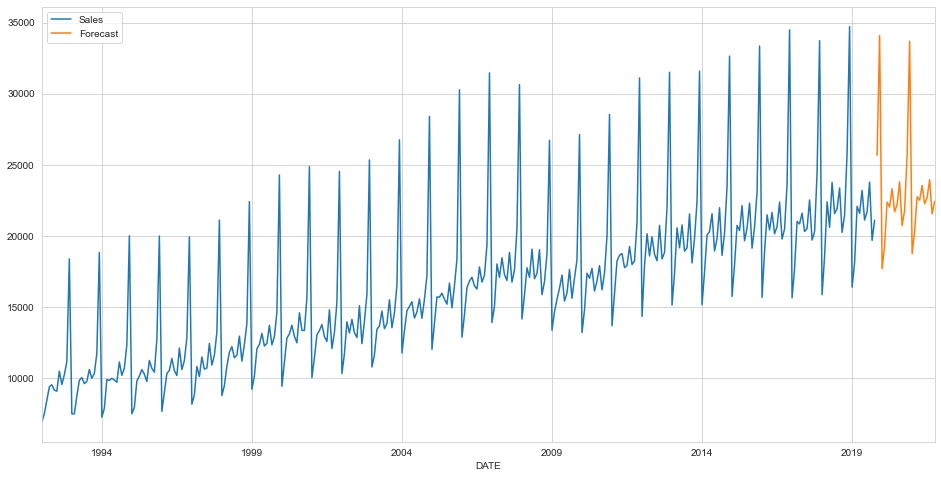

In [64]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

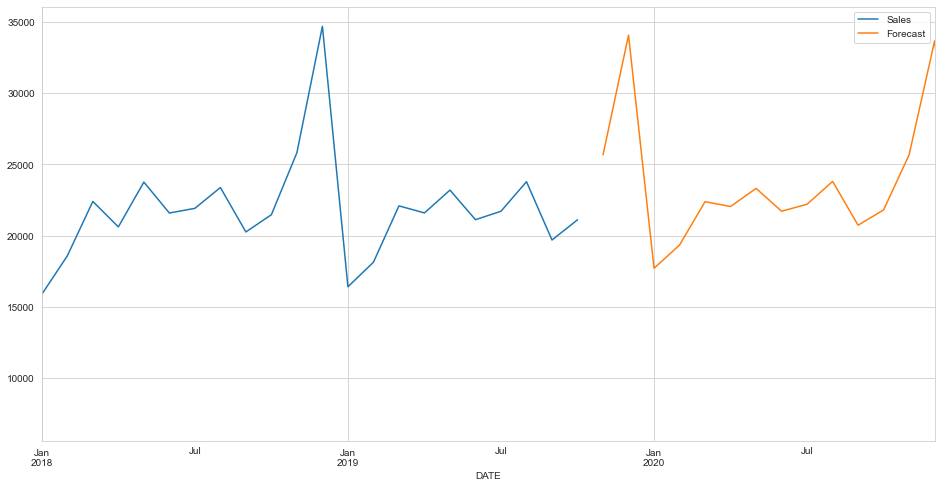

In [65]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')